In [18]:
import os

# Set CUDA devices
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

import sys
import time
from random import shuffle

import numpy as np
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

from tqdm import tqdm, trange
from functools import partial
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Primary device: {device}")

Primary device: cuda:0


In [19]:
class DotDict(dict):
    """Dictionary wrapper to access keys as attributes."""
    def __getattr__(self, key):
        return self.get(key)

In [20]:
def build_global_vocabulary(num_nodes=50):
    """
    Build a canonical ordering of edges (i < j) for up to num_nodes=50.
    Also add special tokens: <PAD>, <START>, <END>
    Returns:
        edge_to_token: dict (i,j) -> token_id
        token_to_edge: dict token_id -> (i,j)
    """
    edges = []
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            edges.append((i, j))
    # Sort them lexicographically => canonical ordering
    edges.sort(key=lambda x: (x[0], x[1]))
    edge_to_token = {}
    token_to_edge = {}
    for idx, (i, j) in enumerate(edges):
        edge_to_token[(i, j)] = idx
        token_to_edge[idx] = (i, j)
    
    # Special Tokens
    PAD_TOKEN = len(edges)
    START_TOKEN = len(edges) + 1
    END_TOKEN = len(edges) + 2
    
    edge_to_token['<PAD>'] = PAD_TOKEN
    edge_to_token['<START>'] = START_TOKEN
    edge_to_token['<END>'] = END_TOKEN
    
    token_to_edge[PAD_TOKEN] = '<PAD>'
    token_to_edge[START_TOKEN] = '<START>'
    token_to_edge[END_TOKEN] = '<END>'
    
    return edge_to_token, token_to_edge


temp_edge2tok, temp_tok2edge = build_global_vocabulary(5)
assert len(temp_edge2tok) == 13, f"5 nodes => 10 edges + 3 special tokens, got {len(temp_edge2tok)}"

In [21]:
class TSPDataset(Dataset):
    """
    Expects lines: x1 y1 x2 y2 ... xN yN output 1 2 3 ... N 1
    We do:
      - parse node coords
      - parse solution tour
      - find top-down edges crossing y-mid
      - find left-right edges crossing x-mid
      - produce a single sequence of tokens:
         [<START>, topDownEdgeTokens..., leftRightEdgeTokens..., <END>]
      - also produce node coords, x_edges, x_edges_values for GCN
      - precompute an 'edge_rank' array for each sample, used in
        generating edge context.
    """
    
    def __init__(self, filepath, num_nodes=50, edge_to_token=None, token_to_edge=None,
                 num_neighbors=-1, device='cpu', voc_size=None):
        super().__init__()
        self.num_nodes = num_nodes
        self.edge_to_token = edge_to_token  # global edge->token mapping
        self.token_to_edge = token_to_edge  # reverse mapping
        self.num_neighbors = num_neighbors
        self.device = device

        # If not provided, infer from dictionary (minus special tokens)
        if voc_size is None:
            # e.g. len(edge_to_token) might already include special tokens
            voc_size = len(edge_to_token)
        self.voc_size = voc_size

        with open(filepath, "r") as f:
            lines = f.readlines()
        self.lines = lines

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        # parse line
        line = self.lines[idx].strip().split()
        if len(line) < 2*self.num_nodes:
            raise ValueError(f"Line {idx} too short to have {2*self.num_nodes} coords.")

        coords = np.array(line[:2*self.num_nodes], dtype=np.float32).reshape(self.num_nodes, 2)

        coords_swapped = coords[:, [1, 0]]
        
        # solution parse
        try:
            output_idx = line.index('output')
        except ValueError:
            raise ValueError("No 'output' in line.")
        # parse solution nodes (1-based => subtract 1)
        sol_nodes = [int(x)-1 for x in line[output_idx+1:] if x.isdigit()]
        if len(sol_nodes) != self.num_nodes+1 or sol_nodes[0] != sol_nodes[-1]:
            raise ValueError("Solution tour not matching expected length or not cyclic.")
        sol_nodes = sol_nodes[:-1]  # remove the repeat

        # compute midpoints
        x_mid = coords[:, 0].mean()
        y_mid = coords[:, 1].mean()

        # define quadrant
        quadrants = np.ones(self.num_nodes, dtype=int)
        quadrants[coords[:, 0] < x_mid] = 2
        quadrants[coords[:, 1] < y_mid] = 4
        quadrants[(coords[:, 0] < x_mid) & (coords[:, 1] < y_mid)] = 3

        # collect top-down edges
        topDownEdgePairs = []
        for i in range(self.num_nodes):
            j = (i + 1) % self.num_nodes
            q_i = quadrants[sol_nodes[i]]
            q_j = quadrants[sol_nodes[j]]
            if ((q_i in [1, 2] and q_j in [3, 4]) or (q_j in [1, 2] and q_i in [3, 4])):
                topDownEdgePairs.append((min(sol_nodes[i], sol_nodes[j]),
                                         max(sol_nodes[i], sol_nodes[j])))

        # collect left-right edges
        leftRightEdgePairs = []
        for i in range(self.num_nodes):
            j = (i + 1) % self.num_nodes
            q_i = quadrants[sol_nodes[i]]
            q_j = quadrants[sol_nodes[j]]
            if ((q_i in [1, 4] and q_j in [2, 3]) or (q_j in [1, 4] and q_i in [2, 3])):
                leftRightEdgePairs.append((min(sol_nodes[i], sol_nodes[j]),
                                           max(sol_nodes[i], sol_nodes[j])))

        # canonical sort & tokenize
        def sort_and_tokenize(edgePairs):
            edgePairs = list(set(edgePairs))
            edgePairs.sort(key=lambda x: (x[0], x[1]))
            tokens = [self.edge_to_token[(i, j)] for (i, j) in edgePairs]
            return tokens

        # special tokens
        START_TOKEN = self.edge_to_token['<START>']
        END_TOKEN = self.edge_to_token['<END>']

        topDownTokens = [START_TOKEN] + sort_and_tokenize(topDownEdgePairs) + [END_TOKEN]
        leftRightTokens = [START_TOKEN] + sort_and_tokenize(leftRightEdgePairs) + [END_TOKEN]

        

        # final sequence = [START_TOKEN] + topDownTokens + leftRightTokens + [END_TOKEN]
        final_token_seq = [START_TOKEN] + topDownTokens + leftRightTokens + [END_TOKEN]

        # distance matrix
        W_val = squareform(pdist(coords, metric='euclidean'))  # (N, N)

        # adjacency matrix
        if self.num_neighbors == -1:
            W = np.ones((self.num_nodes, self.num_nodes), dtype=np.float32)
        else:
            W = np.zeros((self.num_nodes, self.num_nodes), dtype=np.float32)
            knns = np.argpartition(W_val, self.num_neighbors, axis=1)[:, :self.num_neighbors]
            W[np.arange(self.num_nodes)[:, None], knns] = 1
        np.fill_diagonal(W, 2)  # self-connections

        # ---------------------------------------------------------
        # Precompute 'edge_rank' for each edge token in [0..voc_size-3]
        # (exclude <PAD>, <START>, <END>), store in sample.
        # ranking rule:
        #   - If W(i,j) != 1 => rank_val = -999999
        #   - Else rank_val = negative absolute difference => -(abs(meanY - x_mid))
        #     (So that "closer to x_mid" => higher rank_val)
        # ---------------------------------------------------------
        edge_rank = np.full((self.voc_size,), -999999, dtype=np.float32)

        for token_id in range(self.voc_size - 3):
            # skip the special tokens indices at the end
            if token_id not in self.token_to_edge:
                continue
            i, j = self.token_to_edge[token_id]
            # Check adjacency: we treat it as "valid" if W(i, j) == 1 or W(j, i) == 1
            if i < self.num_nodes and j < self.num_nodes:
                if (W[i, j] == 1) or (W[j, i] == 1):
                    meanX = (coords[i, 0] + coords[j, 0]) / 2.0
                    diff = abs(meanX - x_mid)
                    edge_rank[token_id] = -diff

        # to torch
        sample = {
            'coords': torch.tensor(coords, dtype=torch.float, device=self.device),       # (N,2)
            'coords_swapped': torch.tensor(coords_swapped, dtype=torch.float, device=self.device),       # (N,2)
            'x_edges': torch.tensor(W, dtype=torch.long, device=self.device),           # (N,N)
            'x_edges_values': torch.tensor(W_val, dtype=torch.float, device=self.device),  # (N,N)
            'topDownTokens': torch.tensor(topDownTokens, dtype=torch.long, device=self.device),
            'leftRightTokens': torch.tensor(leftRightTokens, dtype=torch.long, device=self.device),
            'token_seq': torch.tensor(final_token_seq, dtype=torch.long, device=self.device),
            'edge_rank': torch.tensor(edge_rank, dtype=torch.float, device=self.device), # (voc_size,)
            'x_mid': torch.tensor(x_mid, dtype=torch.float, device=self.device),
            'y_mid': torch.tensor(y_mid, dtype=torch.float, device=self.device),
        }
        return sample

In [22]:
def collate_fn(batch, edge_to_token):
    """
    Custom collate function to pad sequences to the same length.
    """
    coords = torch.stack([sample['coords'] for sample in batch], dim=0)  # (B, N, 2)
    coords_swapped = torch.stack([sample['coords_swapped'] for sample in batch], dim=0)  # (B, N, 2)
    x_edges = torch.stack([sample['x_edges'] for sample in batch], dim=0)  # (B, N, N)
    x_edges_values = torch.stack([sample['x_edges_values'] for sample in batch], dim=0)  # (B, N, N)
    edge_rank = torch.stack([sample['edge_rank'] for sample in batch], dim=0)  # (B, voc_size)
    x_mid = torch.stack([sample['x_mid'] for sample in batch], dim=0)  # (B,)
    y_mid = torch.stack([sample['y_mid'] for sample in batch], dim=0)  # (B,)
    

    # Determine padding token ID
    PAD_TOKEN = edge_to_token['<PAD>']
    
    # Gather all token sequences
    token_seqs = [sample['token_seq'] for sample in batch]
    # Pad sequences to the maximum length in the batch
    token_seqs_padded = pad_sequence(token_seqs, batch_first=True, padding_value=PAD_TOKEN)  # (B, L)

    # Gather all token sequences
    td_token_seqs = [sample['topDownTokens'] for sample in batch]
    # Pad sequences to the maximum length in the batch
    td_token_seqs_padded = pad_sequence(td_token_seqs, batch_first=True, padding_value=PAD_TOKEN)  # (B, L1)

    # Gather all token sequences
    lr_token_seqs = [sample['leftRightTokens'] for sample in batch]
    # Pad sequences to the maximum length in the batch
    lr_token_seqs_padded = pad_sequence(lr_token_seqs, batch_first=True, padding_value=PAD_TOKEN)  # (B, L2)

    
    return {
        'coords': coords,
        'coords_swapped': coords_swapped,
        'x_edges': x_edges,
        'x_edges_values': x_edges_values,
        'token_seq': token_seqs_padded,  # (B, L) legacy
        'topDownTokens': td_token_seqs_padded,  # (B, L1),
        'leftRightTokens': lr_token_seqs_padded,  # (B, L2)
        'edge_rank': edge_rank,
        'x_mid': x_mid,
        'y_mid': y_mid,
    }

In [23]:
temp_edge2tok, temp_tok2edge = build_global_vocabulary(50)
dataset_dummy = TSPDataset(filepath="tsp-data/tsp50_test_concorde.txt", num_nodes=50, edge_to_token=temp_edge2tok, token_to_edge=temp_tok2edge)
collate_fn = partial(collate_fn, edge_to_token=temp_edge2tok)
dataloader_dummy = DataLoader(dataset_dummy, batch_size=32, shuffle=True, collate_fn=collate_fn)
data_dict = next(iter(dataloader_dummy))
data_dict['coords'].size(), data_dict['x_edges'].size(), data_dict['x_edges_values'].size(), data_dict['topDownTokens'].size(), data_dict['leftRightTokens'].size(), data_dict['edge_rank'].size()

(torch.Size([32, 50, 2]),
 torch.Size([32, 50, 50]),
 torch.Size([32, 50, 50]),
 torch.Size([32, 8]),
 torch.Size([32, 8]),
 torch.Size([32, 1228]))

In [24]:
def visualize_sample(batch, edge_to_token, token_to_edge, N=2):
    """
    Visualize a single sample from the batch.

    Args:
        batch (dict): A batch from DataLoader.
        edge_to_token (dict): Mapping from edge tuples to token IDs.
        token_to_edge (dict): Mapping from token IDs to edge tuples.
        edge_rank (torch.Tensor): Tensor of shape (B, vocab_size) with edge ranks.
        N (int): Number of top edges to highlight.
    """
    # Select the first sample in the batch
    sample = {k: v[0] for k, v in batch.items()}
    
    coords = sample['coords'].cpu().numpy()                # (N, 2)
    x_edges = sample['x_edges'].cpu().numpy()              # (N, N)
    topDownTokens = sample['topDownTokens'].cpu().numpy()  # List of tokens
    leftRightTokens = sample['leftRightTokens'].cpu().numpy()  # List of tokens
    edge_rank_sample = sample['edge_rank'].cpu().numpy()   # (vocab_size,)
    x_mid = sample['x_mid'].cpu().numpy()
    y_mid = sample['y_mid'].cpu().numpy()
    
    plt.figure(figsize=(8, 8))
    
    # Plot all nodes
    plt.scatter(coords[:, 0], coords[:, 1], color='blue', label='Nodes')
    
    '''
    # Plot all valid x_edges as thin grey lines
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            if x_edges[i, j] == 1:
                plt.plot([coords[i, 0], coords[j, 0]],
                         [coords[i, 1], coords[j, 1]],
                         color='grey', linewidth=0.5)
    '''
    
    # Plot top-down edges (excluding special tokens)
    topDownTokens_trimmed = [t for t in topDownTokens if t not in [edge_to_token['<PAD>'], edge_to_token['<START>'], edge_to_token['<END>']]]
    for token in topDownTokens_trimmed:
        if token in token_to_edge:
            i, j = token_to_edge[token]
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     color='red', linewidth=2, label='Top-Down Edge' if token == topDownTokens_trimmed[0] else "")
    
    # Plot left-right edges (excluding special tokens)
    leftRightTokens_trimmed = [t for t in leftRightTokens if t not in [edge_to_token['<PAD>'], edge_to_token['<START>'], edge_to_token['<END>']]]
    for token in leftRightTokens_trimmed:
        if token in token_to_edge:
            i, j = token_to_edge[token]
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     color='green', linewidth=2, label='Left-Right Edge' if token == leftRightTokens_trimmed[0] else "")
    
    # Highlight top N edges based on edge_rank
    if len(topDownTokens_trimmed) > 0:
        # Get ranks for valid topDownTokens
        valid_tokens = torch.tensor(topDownTokens_trimmed, dtype=torch.long)
        ranks = edge_rank_sample[topDownTokens_trimmed]
        # Get top N tokens with highest rank (least negative)
        topN_indices = torch.topk(torch.tensor(ranks), N, largest=True).indices
        topN_tokens = valid_tokens[topN_indices].cpu().numpy()
        for token in topN_tokens:
            if token in token_to_edge:
                i, j = token_to_edge[token]
                plt.plot([coords[i, 0], coords[j, 0]],
                         [coords[i, 1], coords[j, 1]],
                         color='orange', linewidth=3, label='Top-N Edge' if token == topN_tokens[0] else "")
    
    # Plot x_mid and y_mid
    plt.axvline(x=x_mid, color='purple', linestyle='--', label='x_mid')
    plt.axhline(y=y_mid, color='brown', linestyle='--', label='y_mid')
    
    plt.legend()
    plt.title("TSP Sample Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

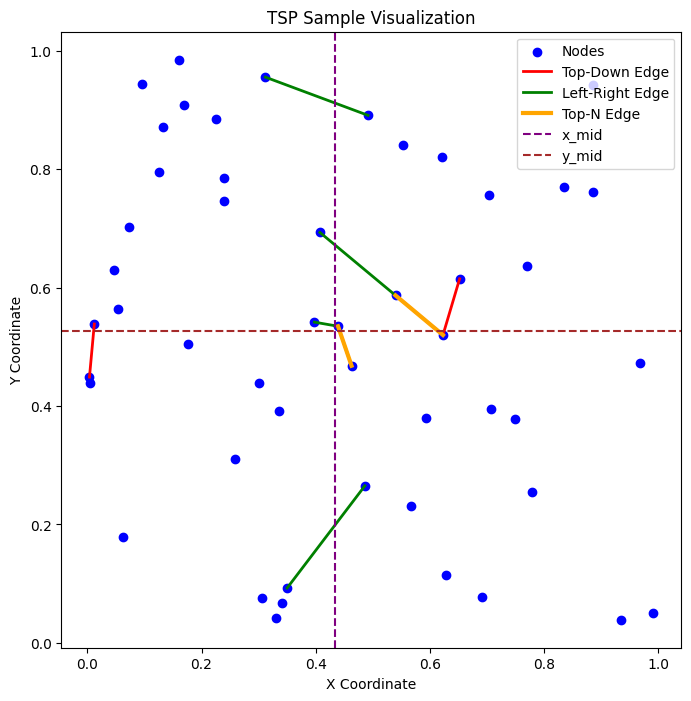

In [25]:
edge2tok, tok2edge = build_global_vocabulary(50) 
dummy_dataset = TSPDataset("tsp-data/tsp50_micro.txt", num_nodes=50, edge_to_token=edge2tok, token_to_edge=tok2edge, device=device)
collate_fn = partial(collate_fn, edge_to_token=edge2tok)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=True, drop_last=False, collate_fn=collate_fn)

sample = next(iter(dummy_loader))
visualize_sample(sample, edge2tok, tok2edge, N=2)

In [26]:
# Define Batch Normalization layers
class BatchNormNode(nn.Module):
    """Batch normalization for node features."""

    def __init__(self, hidden_dim):
        super(BatchNormNode, self).__init__()
        self.batch_norm = nn.BatchNorm1d(hidden_dim, track_running_stats=False)

    def forward(self, x):
        # x: (B, V, H)
        x = x.transpose(1, 2).contiguous()  # (B, H, V)
        x = self.batch_norm(x)  # Apply BatchNorm1d on H
        x = x.transpose(1, 2).contiguous()  # (B, V, H)
        return x

class BatchNormEdge(nn.Module):
    """Batch normalization for edge features."""

    def __init__(self, hidden_dim):
        super(BatchNormEdge, self).__init__()
        self.batch_norm = nn.BatchNorm2d(hidden_dim, track_running_stats=False)

    def forward(self, e):
        # e: (B, V, V, H)
        e = e.permute(0, 3, 1, 2).contiguous()  # (B, H, V, V)
        e = self.batch_norm(e)  # Apply BatchNorm2d on H
        e = e.permute(0, 2, 3, 1).contiguous()  # (B, V, V, H)
        return e

# Define NodeFeatures
class NodeFeatures(nn.Module):
    """Convnet features for nodes."""

    def __init__(self, hidden_dim, aggregation="mean"):
        super(NodeFeatures, self).__init__()
        self.aggregation = aggregation
        self.U = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x, edge_gate):
        # x: (B, V, H)
        # edge_gate: (B, V, V, H)
        Ux = self.U(x)  # (B, V, H)
        Vx = self.V(x).unsqueeze(1)  # (B, 1, V, H)
        gateVx = edge_gate * Vx  # (B, V, V, H)
        if self.aggregation == "mean":
            aggregation = gateVx.sum(dim=2) / (edge_gate.sum(dim=2) + 1e-20)  # (B, V, H)
        else:
            aggregation = gateVx.sum(dim=2)  # (B, V, H)
        return Ux + aggregation  # (B, V, H)

# Define EdgeFeatures
class EdgeFeatures(nn.Module):
    """Convnet features for edges."""

    def __init__(self, hidden_dim):
        super(EdgeFeatures, self).__init__()
        self.U = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x, e):
        # x: (B, V, H)
        # e: (B, V, V, H)
        Ue = self.U(e)  # (B, V, V, H)
        Vx_i = self.V(x).unsqueeze(2)  # (B, V, 1, H)
        Vx_j = self.V(x).unsqueeze(1)  # (B, 1, V, H)
        return Ue + Vx_i + Vx_j  # (B, V, V, H)

# Define ResidualGatedGCNLayer
class ResidualGatedGCNLayer(nn.Module):
    """Convnet layer with gating and residual connection."""

    def __init__(self, hidden_dim, aggregation="sum"):
        super(ResidualGatedGCNLayer, self).__init__()
        self.node_feat = NodeFeatures(hidden_dim, aggregation)
        self.edge_feat = EdgeFeatures(hidden_dim)
        self.bn_node = BatchNormNode(hidden_dim)
        self.bn_edge = BatchNormEdge(hidden_dim)

    def forward(self, x, e):
        # x: (B, V, H)
        # e: (B, V, V, H)
        e_new = self.edge_feat(x, e)  # (B, V, V, H)
        edge_gate = torch.sigmoid(e_new)  # (B, V, V, H)
        x_new = self.node_feat(x, edge_gate)  # (B, V, H)
        e_new = self.bn_edge(e_new)  # (B, V, V, H)
        x_new = self.bn_node(x_new)  # (B, V, H)
        e_new = F.relu(e_new)  # (B, V, V, H)
        x_new = F.relu(x_new)  # (B, V, H)
        return x + x_new, e + e_new  # Residual connections

# Define ResidualGatedGCNModel
class ResidualGatedGCNModel(nn.Module):
    """Residual Gated GCN Model for predicting edge adjacency matrices."""

    def __init__(self, config):
        super(ResidualGatedGCNModel, self).__init__()
        self.num_nodes = config.num_nodes
        self.hidden_dim = config.hidden_dim
        self.num_layers = config.num_layers
        self.aggregation = config.aggregation

        # Node coordinate embedding
        self.nodes_coord_embedding = nn.Linear(config.node_dim, self.hidden_dim, bias=False)

        # Edge value and edge type embedding
        self.edges_values_embedding = nn.Linear(1, self.hidden_dim // 2, bias=False)
        self.edges_embedding = nn.Embedding(config.voc_edges_in, self.hidden_dim // 2)

        # GCN Layers
        self.gcn_layers = nn.ModuleList([
            ResidualGatedGCNLayer(self.hidden_dim, self.aggregation) for _ in range(self.num_layers)
        ])

    def forward(self, x_edges, x_edges_values, x_nodes_coord):
        # Embeddings
        x = self.nodes_coord_embedding(x_nodes_coord)  # (B, V, H)
        e_vals = self.edges_values_embedding(x_edges_values.unsqueeze(-1))  # (B, V, V, H//2)
        e_tags = self.edges_embedding(x_edges)  # (B, V, V, H//2)
        e = torch.cat((e_vals, e_tags), dim=-1)  # (B, V, V, H)

        # GCN layers
        for layer in self.gcn_layers:
            x, e = layer(x, e)  # (B, V, H), (B, V, V, H)

        return x, e

In [27]:
class EdgeTokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, padding_idx):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=padding_idx)
    def forward(self, token_seq):
        # token_seq: (B, L) -> embedded: (B, L, d_model)
        return self.emb(token_seq)

class TransformerEdgeDecoder(nn.Module):
    """
    Autoregressive Transformer decoder that:
      - takes node embeddings as cross-attention context
      - decodes edge tokens in canonical order
      - no positional encoding
    """
    def __init__(self, d_model=256, vocab_size=1228, nhead=4, num_layers=4, padding_idx = 1225):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size

        self.token_embedding = EdgeTokenEmbedding(vocab_size, d_model, padding_idx = padding_idx)
        # no positional encoding

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=d_model*4,
                                                   activation='relu',
                                                   batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, 
                tgt_tokens,         # (B, L) teacher-forced token seq
                node_emb,           # (B, V, H) context for cross-attn
                tgt_mask=None,      # (L, L) for autoregressive
                memory_key_padding_mask=None):
        """
        Returns logits over vocab for each position in tgt_tokens.
        Shapes:
          - tgt_tokens: (B,L)
          - node_emb:   (B,V,H) => memory
        """
        B,L = tgt_tokens.shape
        # embed tokens
        tgt_emb = self.token_embedding(tgt_tokens)  # (B,L,d_model)

        # We'll treat node_emb as memory => shape => (B,V,H).
        # However, TransformerDecoder expects shape (N, S, E) if batch_first=True => we pass (B,V,H).
        # No mask for memory?
        memory = node_emb  # (B,V,H)

        # create subsequent mask for autoregressive
        if tgt_mask is None:
            # (L,L) with True => block
            tgt_mask = self.generate_square_subsequent_mask(L, device=tgt_tokens.device)

        out = self.decoder(tgt=tgt_emb,
                           memory=memory,
                           tgt_mask=tgt_mask)  # shape (B,L,d_model)

        logits = self.output_projection(out) # (B,L,vocab_size)
        return logits

    def generate_square_subsequent_mask(self, sz, device):
        # mask shape (sz, sz) => True means blocked
        mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool, device=device), diagonal=1)
        return mask

In [28]:
class GCNTransformerEdgeModel(nn.Module):
    def __init__(self, config, edge_vocab_size):
        super().__init__()
        self.gcn = ResidualGatedGCNModel(config)
        d_model = config.decoder_d_model
        self.decoder = TransformerEdgeDecoder(d_model=d_model,
                                              vocab_size=edge_vocab_size,
                                              nhead=config.decoder_nhead,
                                              num_layers=config.decoder_layers,
                                              padding_idx=edge_vocab_size-3)
        self.edge_vocab_size = edge_vocab_size
        self.d_model = d_model

    def forward(self, 
                x_edges,            # (B,V,V)
                x_edges_values,     # (B,V,V)
                x_nodes_coord,      # (B,V,2)
                token_seq,          # (B,L) teacher forced
                edge_context = None):         
        """
        Steps:
          Nc: Number of edge context features per sample
          1) GCN => node_emb (concatenated with edge context if any)=> shape (B,V+Nc,H)
          2) decoder => logits => shape (B,L,vocab_size)
        """
        # If edge_context is provided, concatenate it along dim=1
        # Assuming edge_context has shape (B,E,H) and we want (B,V+E,H)
        node_emb, edge_emb = self.gcn(x_edges, x_edges_values, x_nodes_coord)  # (B,V,H)
        if edge_context is not None:
            node_emb = torch.cat([node_emb, edge_context], dim=1)  # (B,V+E,H)
        edge_emb_flat = edge_emb.view(edge_emb.size(0), -1, edge_emb.size(-1))

        # pass to decoder
        logits = self.decoder(token_seq, node_emb)  # (B,L,vocab_size)
        return logits

In [29]:
def generate_edge_context(decoder_embedding, topdown_tokens, edge_rank, N=2):
    """
    Generate edge context embeddings from the top-down tokens for a batch.
    
    Args:
        decoder_embedding (nn.Module): The EdgeTokenEmbedding module.
        topdown_tokens (torch.Tensor): Tensor of shape (B, L_td) containing top-down edge tokens.
        edge_rank (torch.Tensor): Tensor of shape (B, vocab_size) containing precomputed edge ranks.
        N (int): Number of top tokens to select for context.
        pad_idx (int, optional): Padding token ID to exclude.
        start_idx (int, optional): Start token ID to exclude.
        end_idx (int, optional): End token ID to exclude.
        
    Returns:
        torch.Tensor: Edge context embeddings of shape (B, N, d_model).
    """

    B, L = topdown_tokens.shape
    
    # Gather edge ranks for the tokens in topdown_tokens
    # edge_rank has shape (B, vocab_size)
    # topdown_tokens has shape (B, L)
    rank_vals = edge_rank.gather(1, topdown_tokens)  # (B, L)
    
    # Get top N tokens based on rank_vals for each sample in the batch
    topk_vals, topk_indices = torch.topk(rank_vals, N, dim=1, largest=True, sorted=True)  # (B, N)
    
    # Gather the top N tokens using the indices
    topk_tokens = torch.gather(topdown_tokens, 1, topk_indices)  # (B, N)
    # Embed the selected top N tokens
    context_emb = decoder_embedding(topk_tokens)  # (B, N, d_model)
    
    return context_emb  # (B, N, d_model)

In [30]:
###########################################################
# 6) Training: We define a new 'train_one_epoch' that:
#     - loads batch from the new TSPDataset
#     - do 2-part approach: topDown + leftRight
#     - do teacher forcing
#     - cross entropy over each token
#     - use the GCN for context
#    We'll also define a normal crossEntropy ignoring class weights
#    or if we want class weights => we can define them if we see
#    an imbalance in edge tokens. We'll keep it simple now.
###########################################################

def sequence_cross_entropy(logits, target_seq, pad_token):
    """
    logits: (B,L,vocab_size)
    target_seq: (B,L)
    Returns average cross-entropy
    """
    B,L,_ = logits.shape
    # flatten
    logits_flat = logits.reshape(B*L, -1)   # (B*L, vocab_size)
    target_flat = target_seq.reshape(B*L)   # (B*L)
    loss = F.cross_entropy(logits_flat, target_flat, ignore_index=pad_token, reduction='mean')
    return loss

In [31]:
def generate_padded_logit(logits, generated_seq, start_token, end_token, pad_token, device):
    # during evaluation if the end token is encountered, we pad all subsequent tokens
    # this makes loss estimation more accurate
    # Find the first occurrence of end_token in generated_td for each sample

    B, _, C = logits.shape
    #inserting start token at the beginning time step of logit
    start_logits = torch.zeros((B, 1, C), device=device)
    start_logits[:, 0, start_token] = 100.0  # Assign a high value to <START> token
    logits = torch.cat([start_logits, logits], dim=1)  # (B, L+1, vocab_size)

    L = logits.size(1)

    mask_end = (generated_seq == end_token)  # (B, L)
    has_end = mask_end.any(dim=1)            # (B,)
    end_indices = mask_end.float().argmax(dim=1)  # (B,)

    # Create position indices
    
    positions = torch.arange(L, device=device).unsqueeze(0).expand(B, L)  # (B, L)

    # Create a mask for positions after the first end_token
    mask_after_end = positions > end_indices.unsqueeze(1)  # (B, L)
    mask_after_end = mask_after_end & has_end.unsqueeze(1)  # (B, L)
    

    # Set logits after end_token to 0
    logits = logits.masked_fill(mask_after_end.unsqueeze(-1), 0.0)

    # Set pad_idx logits to 100 where mask_after_end is True
    logits[:, :, pad_token] = logits[:, :, pad_token].masked_fill(mask_after_end, 100.0)
    return logits

In [32]:
def two_pass_train_single_epoch(model,
                        dataloader,
                        optimizer,
                        config,
                        epoch,
                        writer=None):
    """
    Example of a single training step with 2-pass approach.
    1) Pass 1 => predict top-down edges.
    2) Compute edge_context embeddings from pass 1's predictions.
    3) Pass 2 => predict left-right edges using node_emb + edge_context.
    """
    model.train()
    running_loss = 0.0
    running_count = 0
    start_t = time.time()

    pad_token = config.special_tokens['PAD']
    start_token = config.special_tokens['START']
    end_token = config.special_tokens['END']

    #progress = tqdm(dataloader, desc=f"Train(Epoch {epoch})", unit="batch")
    #for i, batch in enumerate(progress):
    for batch in dataloader:
        # Unpack batch
        coords = batch['coords']         # (B,N,2)
        coords_swapped = batch['coords_swapped']  # (B,N,2)
        x_edges = batch['x_edges']        # (B,N,N)
        x_edges_values = batch['x_edges_values']  # (B,N,N)
        token_seq_td = batch['topDownTokens']  # (B,L_td)
        token_seq_lr = batch['leftRightTokens'] # (B,L_lr)

        #TODO: Think if we need to shift target sequence by 1 to the right
        # Pass 1: top-down prediction
        logits_td = model(
            x_edges,
            x_edges_values,

    # Set logits after end_token
            coords,
            token_seq_td,
            edge_context=None
        )

        target_seq_td = token_seq_td[:, 1:].contiguous()  # (B, L-1)

        # Adjust logits_td to exclude the last time step
        logits_td = logits_td[:, :-1, :].contiguous()    # (B, L-1, vocab_size)

        # Compute loss with shifted targets
        loss_td = sequence_cross_entropy(logits_td, target_seq_td, pad_token)

        optimizer.zero_grad()
        loss_td.backward()
        optimizer.step()

        B = coords.shape[0]
        '''
        #Generate edge context for pass 2
        B = coords.shape[0]
        real_edge_context = generate_edge_context(model.decoder.token_embedding, token_seq_td, batch['edge_rank'], N=2)
        
        #dummy_edge_context = torch.zeros((B, 5, config.hidden_dim), device=device)

        # Pass 2: left-right prediction using edge_context from pass 1
        logits_lr = model(
            x_edges,
            x_edges_values,
            coords_swapped,
            token_seq_lr,
            edge_context=real_edge_context
        )
        
        target_seq_lr = token_seq_lr[:, 1:].contiguous()  # (B, L-1)

        # Adjust logits_td to exclude the last time step
        logits_lr = logits_lr[:, :-1, :].contiguous()    # (B, L-1, vocab_size)

        # Compute loss with shifted targets
        loss_lr = sequence_cross_entropy(logits_lr, target_seq_lr, pad_token)


        loss = loss_td + loss_lr
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        '''
        running_loss += (loss_td.item())*B
        running_count += B
        avg_loss = running_loss/running_count

        #progress.set_postfix({'loss':f"{avg_loss:.4f}"})
    
    epoch_time = time.time()-start_t
    final_loss = running_loss/running_count
    if writer:
        writer.add_scalar("Train/Epoch_Loss", final_loss, epoch)
    return epoch_time, final_loss


In [33]:
def two_pass_evaluate(model,
                      dataloader,
                      optimizer,
                      config,
                      epoch,
                      writer=None):
    """
    Example of a single evaluation step with 2-pass approach.
    1) Pass 1 => predict top-down edges.
    2) Compute edge_context embeddings from pass 1's predictions.
    3) Pass 2 => predict left-right edges using node_emb + edge_context.
    """
    model.eval()
    running_loss = 0.0
    running_count = 0
    start_t = time.time()

    pad_token = config.special_tokens['PAD']
    start_token = config.special_tokens['START']
    end_token = config.special_tokens['END']

    with torch.no_grad():
        progress = tqdm(dataloader, desc=f"Eval(Epoch {epoch})", unit="batch")
        for i, batch in enumerate(progress):

            # Unpack batch
            coords = batch['coords']                # (B,N,2)
            coords_swapped = batch['coords_swapped'] # (B,N,2)
            x_edges = batch['x_edges']              # (B,N,N)
            x_edges_values = batch['x_edges_values'] # (B,N,N)
            edge_rank = batch['edge_rank']           # (B, vocab_size)
            token_seq_td = batch['topDownTokens']    # (B,L_td)
            token_seq_lr = batch['leftRightTokens']  # (B,L_lr)

            B = coords.shape[0]
            # Pass 1: Predict top-down edges via greedy decoding
            generated_td = torch.full((B, 1), start_token, dtype=torch.long, device=config.device)  # (B,1)
            max_len_td = token_seq_td.size(1)
            for _ in range(max_len_td-1):
                logits_td_step = model(
                    x_edges,
                    x_edges_values,
                    coords,
                    generated_td,
                    edge_context=None
                )  # (B, current_L, vocab_size)
                
                next_token = logits_td_step[:, -1, :].argmax(dim=-1, keepdim=True)  # (B,1)
                generated_td = torch.cat([generated_td, next_token], dim=1)  # (B, L)

            print('Prediction')
            print(generated_td)
            print('Target')
            print(token_seq_td)
            
            
            logits_td = generate_padded_logit(logits_td_step, generated_td, start_token, end_token, pad_token, config.device)
            loss_td = sequence_cross_entropy(logits_td, token_seq_td, pad_token)
            '''
            # Generate edge_context
            real_edge_context = generate_edge_context(
                decoder_embedding=model.module.module.token_embedding,
                topdown_tokens=generated_td,
                edge_rank=edge_rank,
                N=2)  # (B, N, d_model)

            generated_lr = torch.full((B, 1), start_token, dtype=torch.long, device=config.device)  # (B,1)
            max_len_lr = token_seq_lr.size(1)

            for _ in range(max_len_lr-1):
                logits_lr_step = model(
                    x_edges,
                    x_edges_values,
                    coords_swapped,
                    generated_lr,
                    edge_context=real_edge_context
                )  # (B, current_L, vocab_size)
                next_token = logits_lr_step[:, -1, :].argmax(dim=-1, keepdim=True)  # (B,1)
                generated_lr = torch.cat([generated_lr, next_token], dim=1)  # (B, L+1)

            # logits_lr is the logits from the last step
            logits_lr = generate_padded_logit(logits_lr_step, generated_lr, start_token, end_token, pad_token, config.device)
            loss_lr = sequence_cross_entropy(logits_lr, token_seq_lr, pad_token)
            '''

            running_loss += (loss_td).item() * B
            running_count += B
            avg_loss = running_loss / running_count

            progress.set_postfix({'loss': f"{avg_loss:.4f}"})

    epoch_time = time.time() - start_t
    final_loss = running_loss / running_count
    if writer:
        writer.add_scalar("Eval/Epoch_Loss", final_loss, epoch)
    return epoch_time, final_loss


In [34]:
edge2tok, tok2edge = build_global_vocabulary(50) 
dummy_dataset = TSPDataset("tsp-data/tsp50_micro.txt", num_nodes=50, edge_to_token=edge2tok, token_to_edge=tok2edge, device=device)
collate_fn = partial(collate_fn, edge_to_token=edge2tok)
dummy_loader = DataLoader(dummy_dataset, batch_size=4, shuffle=True, drop_last=False, collate_fn=collate_fn)
dummy_val_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

cfg_autoreg = DotDict({
    'num_nodes':50,
    'hidden_dim':8,
    'num_layers':3,
    'aggregation':'mean',
    'node_dim':2,
    'voc_edges_in':3,   
    'decoder_d_model':8,
    'decoder_nhead':2,
    'decoder_layers':1,
    'special_tokens': {'PAD': edge2tok['<PAD>'], 'START': edge2tok['<START>'], 'END': edge2tok['<END>']},
    'device': device
})

model_auto = GCNTransformerEdgeModel(cfg_autoreg, edge_vocab_size=len(edge2tok)).to(device)
#model_auto = nn.DataParallel(model_auto)

opt_ = torch.optim.Adam(model_auto.parameters(), lr=1e-3)

for epoch in range(1, 1500):
    et, lss = two_pass_train_single_epoch(
        model_auto, 
        dummy_loader, 
        opt_, 
        cfg_autoreg, 
        epoch=epoch, 
        writer=None
    )
    print(f"Epoch {epoch}, train loss={lss}")
_, val_lss = two_pass_evaluate(
        model_auto, 
        dummy_val_loader, 
        opt_, 
        cfg_autoreg, 
        epoch=epoch, 
        writer=None
    )

Epoch 1, train loss=7.281490993499756
Epoch 2, train loss=7.222031307220459
Epoch 3, train loss=7.169310855865478
Epoch 4, train loss=7.121131038665771
Epoch 5, train loss=7.062925148010254
Epoch 6, train loss=7.007898330688477
Epoch 7, train loss=6.928836727142334
Epoch 8, train loss=6.899309253692627
Epoch 9, train loss=6.812558555603028
Epoch 10, train loss=6.766373348236084
Epoch 11, train loss=6.666946506500244
Epoch 12, train loss=6.59032974243164
Epoch 13, train loss=6.560261249542236
Epoch 14, train loss=6.469651794433593
Epoch 15, train loss=6.38899974822998
Epoch 16, train loss=6.343532848358154
Epoch 17, train loss=6.302441596984863
Epoch 18, train loss=6.180909061431885
Epoch 19, train loss=6.138235759735108
Epoch 20, train loss=6.041619491577149
Epoch 21, train loss=5.9518474578857425
Epoch 22, train loss=5.915154552459716
Epoch 23, train loss=5.816425418853759
Epoch 24, train loss=5.740346431732178
Epoch 25, train loss=5.672753047943115
Epoch 26, train loss=5.601634693145

KeyboardInterrupt: 